# Bengali.AI - Training loop

The notebook was created in Kaggle. It only contains the code for the training loop, and the (preprocessed) data still has  to be put into a `Dataset` object (see below) to initialize the train/test datasets and loaders. After this is done, the training loop should work but I have only tested it as far as possible with a (simpler) placeholder dataset. Some parts do not have a defined output yet (e.g., model output), thus a certain output format is assumed for now in those cases.

In [1]:
import re
from torch._six import container_abcs, string_classes, int_classes
from torch.utils.data._utils import collate

np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")

def _new_default_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.cat(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return _new_default_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: _new_default_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(_new_default_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        transposed = zip(*batch)
        return [_new_default_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))
    
collate.default_collate = _new_default_collate

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SIZE = 128
BATCH_SIZE = 32
PATH = 'model.pt'

In [4]:
train_images = np.load('train_image_data.npy')

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
        super(ResidualBlock, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x


class ResNet34(nn.Module):
    """
    from 'ResNet-34 PyTorch Starter Kit'
    """

    def __init__(self):
        super(ResNet34, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.block2 = nn.Sequential(
            nn.MaxPool2d(1, 1),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64, 2)
        )

        self.block3 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128, 2)
        )

        self.block4 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256, 2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256, 512),
            ResidualBlock(512, 512, 2)
        )

        self.avgpool = nn.AvgPool2d(2)
        # grapheme_root
        self.fc1 = nn.Linear(2048, 168)
        # vowel_diacritic
        self.fc2 = nn.Linear(2048, 11)
        # consonant_diacritic
        self.fc3 = nn.Linear(2048, 7)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1, x2, x3

In [6]:
train_labels = pd.read_csv('train.csv').iloc[:, 1:-1]
train_labels.head()

,grapheme_root,vowel_diacritic,consonant_diacritic
0,15,9,5
1,159,0,0
2,22,3,5
3,53,2,2
4,71,9,5


TODO: split dataset into train and validation set.

In [7]:
model = ResNet34() # initialize model here
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
class Cutout(object):
    def __init__(self, num_holes, length):    
        """Randomly mask out one or more patches from an image.
        
        Args:
            n_holes = [int] number of patches to cut out of the image
            length  = [int] the length (in pixels) of each square patch
        """
        self.num_holes = num_holes
        self.length = length

    def __call__(self, img):
      """
      Args:
          img = [Tensor] tensor image of size (1x128x128)
      Returns [Tensor]:
          Image with num_holes of dimension length x length cut out of it.
      """
      coords = torch.randint(high=SIZE, size=(2, self.num_holes))

      x1, y1 = torch.clamp(coords - self.length // 2, 0, SIZE)
      x2, y2 = torch.clamp(coords + self.length // 2, 0, SIZE)

      mask = torch.ones_like(img)
      for x1, y1, x2, y2 in zip(x1, y1, x2, y2):
          mask[:, y1:y2, x1:x2] = 0

      return img * mask

In [9]:
# Put data into Dataset object
class BengaliDataset(Dataset):
    def __init__(self, images, labels, device, num_augmentations=4):
        super(Dataset, self).__init__()
        
        self.images = images
        self.transform_image = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(
                degrees=(-8, 8),
                translate=(1 / 24, 1 / 24),
                scale=(8 / 9, 10 / 9)
            ),
            transforms.ToTensor()
        ])
        self.transform_tensor = transforms.Compose([
            transforms.Normalize(mean=(0.071371482,), std=(0.20764154,)),
            Cutout(8, 12)
        ])
        
        self.labels = torch.tensor(labels.to_numpy(), device=device)
        counts = labels.apply(pd.Series.value_counts).to_numpy().T
        counts_max = np.nanmax(counts, axis=1, keepdims=True)
        self.ratio_counts = torch.tensor(counts_max // counts, device=device)
        self.mod_counts = torch.tensor(counts_max % counts, device=device)
        
        self.device = device
        
        self.reset()
        
    def reset(self):
        self.current_counts = torch.zeros_like(self.mod_counts)

    def __len__(self):
        return len(self.images)
    
    def _num_augmentations(self, labels):
        counts = self.current_counts[[0, 1, 2], labels]
        extra = counts < self.mod_counts[[0, 1, 2], labels]

        num_augmentations = self.ratio_counts[[0, 1, 2], labels] + extra
        self.current_counts[[0, 1, 2], labels] += extra

        return num_augmentations.long()
    
    def _split(self, array, diffs):
        sub_arrays = []
        diffs = torch.cat((torch.zeros_like(diffs)[:1], diffs))
        sections = torch.cumsum(diffs, dim=0)
        for start, end in zip(sections, sections[1:]):
            sub_arrays.append(torch.stack(tuple(array[start:end])))

        return sub_arrays

    def __getitem__(self, idx):
        image = self.images[idx]
        labels = self.labels[idx]
        num_augmentations = self._num_augmentations(labels)
        
        images = []
        for _ in range(sum(num_augmentations)):
            img = self.transform_image(image).to(self.device)
            images.append(self.transform_tensor(img))
        images = self._split(images, num_augmentations)           
        
        labels = labels.repeat_interleave(num_augmentations)
        labels = self._split(labels, num_augmentations)

        return tuple(images) + tuple(labels)

In [10]:
train_dataset = BengaliDataset(train_images, train_labels, device) # alternatively use TensorDataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # num_workers can be set
# TODO: test_dataset and test_loader (=validation set)

In [11]:
def eval_metric(pred_dict, true_dict):
    """
    Competition evaluation metric adapted from:
    https://www.kaggle.com/c/bengaliai-cv19/overview/evaluation
    The metric describes the weighted average of component 
    macro-averaged recalls.
    
    Args:
        pred_dict = [dict] dictionary with components as keys and
                           lists of predictions as values
        true_dict = [dict] dictionary with components as key and
                           lists of targets as values
    
    Returns [float]:
        Weighted average of component macro-averaged recalls
    """
    scores = []
    for key in ['grapheme', 'vowel', 'consonant']:
        score = recall_score(true_dict[key], pred_dict[key], average='macro')
        scores.append(score)
    return np.average(scores, weights=[2, 1, 1])

In [12]:
def update_dicts(key, pred_dict, true_dict, pred, target):
    """
    Updates two dictionaries given a key with the provided values.
    Assumes batches.
    
    Args:
        key       = [string] the key in the dictionary to update
        pred_dict = [dict] dictionary with components as keys and
                           lists of predictions as values
        true_dict = [dict] dictionary with components as key and
                           lists of targets as values
        pred      = [torch.Tensor] tensor of (raw) predictions
        target    = [torch.Tensor] tensor of targets
    """
    _, pred = torch.max(pred.data, 1)
    pred_list = pred.tolist()
    target_list = target.tolist()
    pred_dict[key] += pred_list
    true_dict[key] += target_list

Naming convention:
- `x` = input
- `t` = target
- `y` = predicted output


In [13]:
def train(model, train_loader, optimizer, criterion, epochs=10, path=PATH):
    losses = [] # keep track of losses
    scores = [] # keep track of scores
    
    for epoch in range(epochs):
        running_loss = 0.0
        pred_dict = {'grapheme': [], 'vowel': [], 'consonant': []}
        true_dict = {'grapheme': [], 'vowel': [], 'consonant': []}
        
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # unpack inputs and targets
            x_graph, x_vowel, x_conso, t_graph, t_vowel, t_conso = data # depends on what is returned by Dataset.__getitem__
            # x = torch.cat((x_graph, x_vowel, x_conso))
            
            x_components = (x_graph, x_vowel, x_conso)
            t_components = (t_graph, t_vowel, t_conso)
            components = ['grapheme', 'vowel', 'consonant']
            for idx, (x, t) in enumerate(zip(x_components, t_components)):
                # predict
                y = model(x)
                loss = criterion(y[idx], t)
                
                # update model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
                # TODO: different running losses for the different subproblems
                running_loss += loss.item() if idx == 0 else 0
                      
                 # update pred_dict and true_dict
                update_dicts(components[idx], pred_dict, true_dict, y[idx], t)
                
                del y, loss
        
        losses.append(running_loss / len(train_loader))
        score = eval_metric(pred_dict, true_dict)
        scores.append( score )
        
        print('Loss: {:.3f}'.format( running_loss / len(train_loader) ))
        print('Score: {:.3f}'.format( score ))
        
    # save model weights at path
    torch.save(model.state_dict(), path)
    
    return losses, scores            

In [ ]:
losses, scores = train(model, train_loader, optimizer, criterion, epochs=2)

In [52]:
def plot_perf(losses, scores):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(losses)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss over epochs', size=14)
    ax[1].plot(scores)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Score')
    ax[1].set_title('Score over epochs', size=14)

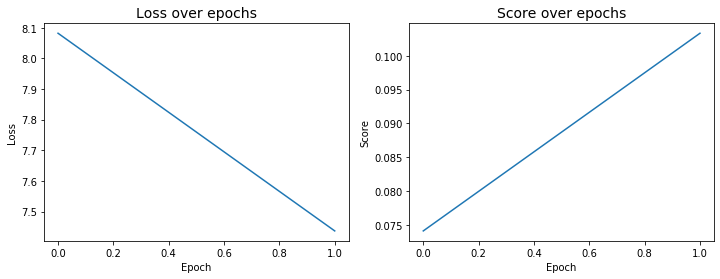

In [53]:
plot_perf(losses, scores)